## Adaptation du tutoriel vers le texte

In [1]:
import numpy as np
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import mnist

import matplotlib.pyplot as plt
from random import randrange
from math import floor

from keras.utils import np_utils

from modules.loader import ComptaDataLoader

print('env: ', os.environ['CONDA_DEFAULT_ENV'])
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.
env:  deep-learning


## Téléchargement des données

In [2]:
loader = ComptaDataLoader()
loader.ensure_data_loaded()

Les fichiers sont correctement téléchargés


## Creation d'un CSV

In [3]:
# loader.create_csv(100)

## Lecture des csv

In [4]:
path = r"../datas/CURATED/"

lettre_data = np.genfromtxt(path + '1000_data.csv', delimiter=',')
lettre_labels = np.genfromtxt(path + '1000_labels.csv', delimiter=',')

lettre_data = np.apply_along_axis(lambda row: row.reshape(28,28), 1, lettre_data)

print(
    lettre_data.shape
    , lettre_labels.shape
)

# beaucoup d'images (60000)
chiffre_images = mnist.train_images()
chiffre_labels = mnist.train_labels() + 26
# moins d'images (10000)
# chiffre_images = mnist.test_images()
# chiffre_labels = mnist.test_labels() + 26

# Mélange de manière synchronisé la data et les labels
randomize = np.arange(len(chiffre_images))
np.random.shuffle(randomize)
chiffre_images = chiffre_images[randomize]
chiffre_labels = chiffre_labels[randomize]

chiffre_images = chiffre_images[:10000]
chiffre_labels = chiffre_labels[:10000]

print(
    chiffre_images.shape
    , chiffre_labels.shape
)

(26000, 28, 28) (26000,)
(10000, 28, 28) (10000,)


## Preprocessing d'image

In [6]:
# Reunification des jeux
data = np.concatenate((lettre_data, chiffre_images))
labels = np.concatenate((lettre_labels, chiffre_labels))

data = np.expand_dims(data, axis=3)
labels = to_categorical(labels)

# Explication:
# 0     127.5   255   3 valeurs par defaut
# 0     .25     1     /255
# -.5   0       .5    -.5
data = (data / 255) - 0.5

# Mélange de manière synchronisé la data et les labels
randomize = np.arange(len(data))
np.random.shuffle(randomize)
data = data[randomize]
labels = labels[randomize]

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(data)


print(
    data.shape, '\n',
    labels.shape, '\n',
    [np.argmax(row) for row in labels[:10]]
)

(36000, 28, 28, 1) 
 (36000, 36) 
 [14, 11, 1, 22, 25, 12, 0, 33, 12, 12]


## Je plot une lettre:

C'est un B


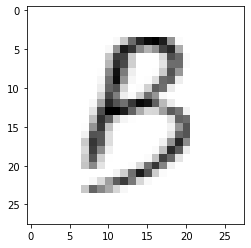

In [7]:
nb_random = randrange(0, len(data))

img = data[nb_random]
plt.imshow(img, cmap='Greys')
print( "C'est un " + loader.int_to_letter(np.argmax(labels[nb_random])))

del(img, nb_random)

## Construction du modèle

In [8]:
model = Sequential([
  layers.Conv2D(28, 3, activation='relu'),
  layers.Conv2D(56, 3, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(36, activation='softmax')
])

model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

## Entrainement du modèle

In [9]:
history = model.fit(
  data,
  labels,
  epochs=12,
  validation_split=0.25,
  verbose=2
)

model.save(str(int(len(data)/36)) + '_CNN.h5')
print(
  'Creation de ' + str(int(len(data)/36)) + '_CNN.h5'
)

Train on 27000 samples, validate on 9000 samples
Epoch 1/12
 - 53s - loss: 1.1659 - accuracy: 0.6654 - val_loss: 0.3071 - val_accuracy: 0.9137
Epoch 2/12
 - 51s - loss: 0.5096 - accuracy: 0.8442 - val_loss: 0.2220 - val_accuracy: 0.9349
Epoch 3/12
 - 50s - loss: 0.3864 - accuracy: 0.8812 - val_loss: 0.1878 - val_accuracy: 0.9426
Epoch 4/12
 - 53s - loss: 0.3281 - accuracy: 0.8983 - val_loss: 0.1759 - val_accuracy: 0.9471
Epoch 5/12
 - 52s - loss: 0.2819 - accuracy: 0.9089 - val_loss: 0.1656 - val_accuracy: 0.9487
Epoch 6/12
 - 50s - loss: 0.2477 - accuracy: 0.9177 - val_loss: 0.1594 - val_accuracy: 0.9544
Epoch 7/12
 - 52s - loss: 0.2295 - accuracy: 0.9234 - val_loss: 0.1503 - val_accuracy: 0.9541
Epoch 8/12
 - 52s - loss: 0.2114 - accuracy: 0.9291 - val_loss: 0.1523 - val_accuracy: 0.9546
Epoch 9/12
 - 53s - loss: 0.1951 - accuracy: 0.9350 - val_loss: 0.1486 - val_accuracy: 0.9573
Epoch 10/12
 - 52s - loss: 0.1780 - accuracy: 0.9400 - val_loss: 0.1540 - val_accuracy: 0.9550
Epoch 11/1

In [11]:
def transform_to_letter(index: int):
    alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    return alphabet[index]

# from keras.models import load_model
# model = load_model('1000_CNN.h5')

nb_element = 29
nb_random = randrange(0, len(data)-nb_element)


prediction = [ transform_to_letter(lettre) for lettre in np.argmax(model.predict(data[nb_random:nb_random+nb_element]) , axis=1)]
verite = [ transform_to_letter(np.argmax(lettre))  for lettre in labels[nb_random:nb_random+nb_element] ] 

print(
    'Prediciton:\t', prediction,
    '\nVérité:\t\t', verite,
    '\nLe modèle donne un resultat juste ? ', prediction == verite
)

Prediciton:	 ['V', '1', 'O', 'B', '1', 'T', '0', 'V', 'V', 'O', 'M', 'Z', '5', '9', 'J', 'W', 'T', 'I', 'G', 'X', 'O', 'T', 'O', 'C', 'S', 'F', 'K', '4', '0'] 
Vérité:		 ['V', '1', 'O', 'B', '1', 'T', '0', 'V', 'V', 'O', 'M', 'Z', '5', '9', 'J', 'W', 'T', 'I', 'G', 'X', 'O', 'T', 'O', 'C', 'S', 'F', 'K', '4', '0'] 
Le modèle donne un resultat juste ?  True


# Les hyperparamètres à tester:

## Network Depth
What happens if we add or remove Convolutional layers? How does that affect training and/or the model’s final performance?
```
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),

  Conv2D(num_filters, filter_size),
  
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(10, activation='softmax'),
])
```

## Dropout
What if we tried adding Dropout layers, which are commonly used to prevent overfitting (surentrainement) ?
```
from tensorflow.keras.layers import Dropout

model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  
  Dropout(0.5),

  Flatten(),
  Dense(10, activation='softmax'),
])
```

## Fully-connected Layers
What if we add fully-connected layers between the Convolutional outputs and the final Softmax layer? This is something commonly done in CNNs used for Computer Vision.

```
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),

  Dense(64, activation='relu'),
  
  Dense(10, activation='softmax'),
])
```

## Convolution Parameters

What if we play with the Conv2D parameters? For example:

```
Conv2D(
    num_filters,
    filter_size,
    input_shape=(28, 28, 1),

    strides=2,
    padding='same',
    activation='relu',
    
  ),
```

code complet du tutoriel :

``` python
# The full CNN code!
####################
import numpy as np
import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

num_filters = 8
filter_size = 3
pool_size = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(10, activation='softmax'),
])

# Compile the model.
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

# Train the model.
model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=3,
  validation_data=(test_images, to_categorical(test_labels)),
)

# Save the model to disk.
model.save_weights('cnn.h5')

# Load the model from disk later using:
# model.load_weights('cnn.h5')

# Predict on the first 5 test images.
predictions = model.predict(test_images[:5])

# Print our model's predictions.
print(np.argmax(predictions, axis=1)) # [7, 2, 1, 0, 4]

# Check our predictions against the ground truths.
print(test_labels[:5]) # [7, 2, 1, 0, 4]
```